# Figure 4 line plot in manuscript 

> Clean version of `compare-sw.ipynb` 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import json
import gcsfs
from scipy.signal import detrend
from scipy import stats
from scipy.stats import linregress
import cmocean

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

era1022 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/surf_ds_2010_22.zarr'))
era23 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/gom_updated.zarr'))

era24_sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-sst_up2june.zarr'))
era24_ssr = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-ssr_up2june.zarr'))
era24_rest = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-rest_up2june.zarr'))

In [2]:
era1023 = xr.concat([era1022, era23], dim='time')
era1023_sliced = era1023.sel(longitude=slice(-100,-80))

In [3]:
era24_r = era24_rest.sel(longitude=slice(-100,-80))
era_fluxes2024 = xr.merge([era24_r, era24_ssr, era24_sst])

In [4]:
era1 = xr.concat([era1023_sliced, era_fluxes2024], dim='time')

In [5]:
era1

<xarray.Dataset> Size: 17GB
Dimensions:    (time: 127080, latitude: 41, longitude: 81)
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 1MB 2010-01-01 ... 2024-06-30T23:00:00
Data variables:
    slhf       (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>
    ssr        (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>
    sst        (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>
    str        (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-21 17:02:34 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [6]:
ssr = xr.open_dataset('era1.nc')
sst = xr.open_dataset('era2.nc')
rest_flx_24 = xr.open_dataset('era-rofluxes.nc')
str_ds = xr.open_dataset('str.nc')

In [7]:
ssr_cut = ssr.isel(latitude=slice(None, -16), 
         longitude=slice(None, -36)).rename_dims({'valid_time':'time'}).rename_vars({'valid_time':'time'}).drop_vars(('expver', 
                                                                                                                     'number'))
sst_cut = sst.isel(latitude=slice(None, -16), 
         longitude=slice(None, -36)).rename_dims({'valid_time':'time'}).rename_vars({'valid_time':'time'}).drop_vars(('expver', 
                                                                                                                     'number'))
rest_flx_cut = rest_flx_24.isel(longitude=slice(None, 
                                -36)).rename_dims({'valid_time':'time'}).rename_vars({'valid_time':'time'}).drop_vars(('expver', 
                                                                                                                     'number'))
str_cut = str_ds.isel(longitude=slice(None, 
                                -36)).rename_dims({'valid_time':'time'}).rename_vars({'valid_time':'time'}).drop_vars(('expver', 
                                                                                                                     'number'))

In [20]:
merged_ssr = xr.concat([era1.ssr.isel(time=slice(None, -720)), ssr_cut.ssr], dim='time')
mssr_ds = merged_ssr.to_dataset(name='ssr')
merged_sst = xr.concat([era1.sst.isel(time=slice(None, -720)), sst_cut.sst], dim='time')
msst_ds = merged_sst.to_dataset(name='sst')

mrest = xr.merge([rest_flx_cut.drop_vars('strd'), str_cut])
mrest_ds = xr.concat([era1.drop_vars(('ssr','sst')), mrest], dim='time')

In [22]:
mrest_ds

<xarray.Dataset> Size: 10GB
Dimensions:    (time: 131496, latitude: 41, longitude: 81)
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 1MB 2010-01-01 ... 2024-12-31T23:00:00
Data variables:
    slhf       (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>
    str        (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-21 17:02:34 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [18]:
mssr_ds

<xarray.Dataset> Size: 3GB
Dimensions:    (latitude: 41, longitude: 81, time: 131496)
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 1MB 2010-01-01 ... 2024-12-31T23:00:00
Data variables:
    ssr        (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>

In [19]:
msst_ds

<xarray.Dataset> Size: 3GB
Dimensions:    (latitude: 41, longitude: 81, time: 131496)
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 1MB 2010-01-01 ... 2024-12-31T23:00:00
Data variables:
    sst        (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>

In [23]:
era = xr.merge([mrest_ds, mssr_ds, msst_ds])

In [24]:
era

<xarray.Dataset> Size: 17GB
Dimensions:    (time: 131496, latitude: 41, longitude: 81)
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 1MB 2010-01-01 ... 2024-12-31T23:00:00
Data variables:
    slhf       (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>
    str        (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>
    ssr        (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>
    sst        (time, latitude, longitude) float64 3GB dask.array<chunksize=(2374, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-21 17:02:34 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

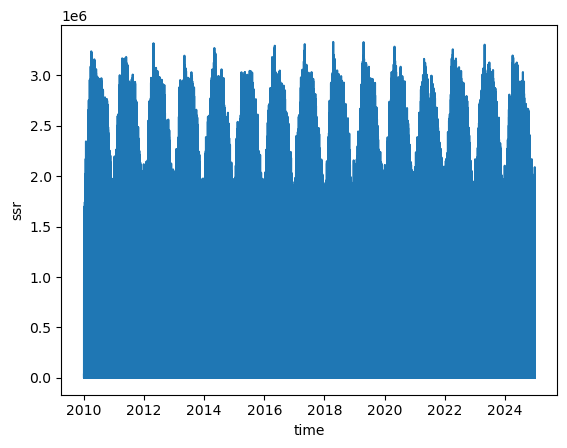

In [25]:
era.ssr.mean(['latitude', 'longitude']).plot()

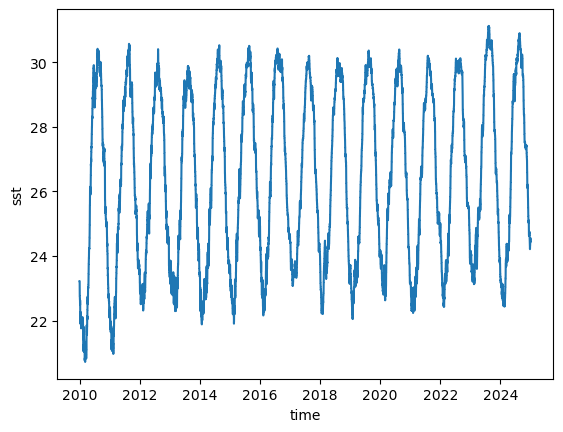

In [26]:
(era.sst-273.15).mean(['latitude', 'longitude']).plot()

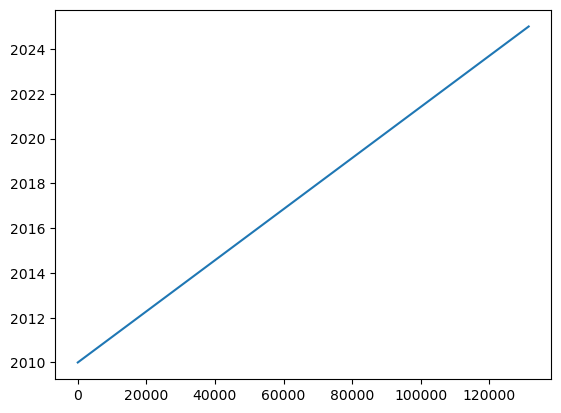

In [27]:
plt.plot(era.time.values)

In [28]:
## convert from J/m^2 -> W/m^2
era_wm2 = era.drop_vars('sst') / (60*60)
#resample to daily freq (hourly too noisy
era_daily = era_wm2.resample(time='D').mean('time')

#change from kelvin to celsius and resample to daily freq
era_sst = (era.sst-273.15).resample(time='D').mean('time')

In [29]:
sst = era_sst.load()

In [30]:
surfs = era_daily.load()

In [31]:
surfs

<xarray.Dataset> Size: 582MB
Dimensions:    (time: 5479, latitude: 41, longitude: 81)
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 44kB 2010-01-01 2010-01-02 ... 2024-12-31
Data variables:
    slhf       (time, latitude, longitude) float64 146MB -21.1 -23.72 ... -122.2
    sshf       (time, latitude, longitude) float64 146MB -32.74 ... -10.51
    str        (time, latitude, longitude) float64 146MB -99.24 -98.0 ... -72.58
    ssr        (time, latitude, longitude) float64 146MB 136.0 136.4 ... 185.0
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-21 17:02:34 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

## Take monthly climatology

In [32]:
mo_clim_e_sst = sst.groupby('time.month').mean(['time', 'latitude', 'longitude'])
emonthly_sst = sst.resample(time='ME').mean().mean(['latitude', 'longitude'])

mo_clim_e_surfs = surfs.groupby('time.month').mean(['time', 'latitude', 'longitude'])
emonthly_surfs = surfs.resample(time='ME').mean().mean(['latitude', 'longitude'])

mo_clim_sans_ssr = mo_clim_e_surfs.drop_vars('ssr')
emonthly_sans_ssr = emonthly_surfs.drop_vars('ssr')

In [33]:
mo_clim_e_sst

<xarray.DataArray 'sst' (month: 12)> Size: 96B
array([23.03699276, 22.71272578, 23.35845232, 24.69600346, 26.63819541,
       28.60535521, 29.57377534, 30.09803423, 29.58209624, 28.17267706,
       26.09576546, 24.39035957])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [34]:
emonthly_sst.sel(time='2024')

<xarray.DataArray 'sst' (time: 12)> Size: 96B
array([23.0136254 , 22.64149763, 23.84178295, 24.6643005 , 27.42317793,
       29.21822045, 29.92701446, 30.66245567, 30.07766132, 28.28460185,
       26.91843919, 24.78788116])
Coordinates:
  * time     (time) datetime64[ns] 96B 2024-01-31 2024-02-29 ... 2024-12-31

In [46]:
emonthly_surfs.ssr.sel(time='2024')

<xarray.DataArray 'ssr' (time: 12)> Size: 96B
array([128.29534638, 170.86056241, 204.70417563, 250.37696176,
       265.26553258, 246.68705116, 246.18302965, 242.11683018,
       197.050253  , 176.82378142, 147.87610325, 127.94365006])
Coordinates:
  * time     (time) datetime64[ns] 96B 2024-01-31 2024-02-29 ... 2024-12-31

In [36]:
mo_clim_sans_ssr.to_array().sum('variable')

<xarray.DataArray (month: 12)> Size: 96B
array([-234.57208185, -198.37383888, -200.34057785, -188.94926576,
       -184.94143406, -184.55192536, -191.1080727 , -198.1208325 ,
       -200.2683191 , -238.46692753, -241.1833143 , -220.02582599])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [39]:
emonthly_sans_ssr.to_array().sum('variable').sel(time='2024')

<xarray.DataArray (time: 12)> Size: 96B
array([-217.91141335, -220.53086316, -175.58999006, -202.37474844,
       -158.31113041, -194.04170371, -180.18461711, -196.87136651,
       -191.05286085, -247.09538187, -222.89127081, -230.28832017])
Coordinates:
  * time     (time) datetime64[ns] 96B 2024-01-31 2024-02-29 ... 2024-12-31

In [41]:
#expand 2024 so you can plot it below
import pandas as pd

date_range = ['2024-01-31T00:00:00.000000000', '2024-02-29T00:00:00.000000000',
       '2024-03-31T00:00:00.000000000', '2024-04-30T00:00:00.000000000',
       '2024-05-31T00:00:00.000000000', '2024-06-30T00:00:00.000000000',
       '2024-07-31T00:00:00.000000000', '2024-08-31T00:00:00.000000000',
       '2024-09-30T00:00:00.000000000', '2024-10-31T00:00:00.000000000',
       '2024-11-30T00:00:00.000000000', '2024-12-31T00:00:00.000000000']
months2024 = pd.to_datetime(date_range)

#first 5 values come from latest May data 
array_sst = [23.0136254 , 22.64149763, 23.84178295, 24.6643005 , 27.42317793, 29.21822045, 
             29.92701446, 30.66245567, 30.07766132, 28.28460185, 26.91843919, 24.78788116]
array_ssr = [128.29534638, 170.86056241, 204.70417563, 250.37696176, 265.26553258, 246.68705116, 
             246.18302965, 242.11683018, 197.050253  , 176.82378142, 147.87610325, 127.94365006]
array_rest = [-217.91141335, -220.53086316, -175.58999006, -202.37474844, -158.31113041, -194.04170371, 
               -180.18461711, -196.87136651, -191.05286085, -247.09538187, -222.89127081, -230.28832017]

array_sst2024 = xr.DataArray(data=array_sst, coords={'time':months2024})
array_ssr2024 = xr.DataArray(data=array_ssr, coords={'time':months2024})
array_rest2024 = xr.DataArray(data=array_rest, coords={'time':months2024})

#insert to emonthly
emonthly_filled_sst = xr.concat([emonthly_sst.sel(time=slice(None, '2023')), array_sst2024], dim='time')
emonthly_filled_ssr = xr.concat([emonthly_surfs.ssr.sel(time=slice(None, '2023')), array_ssr2024], dim='time')
emonthly_filled_rest = xr.concat([emonthly_sans_ssr.sel(time=slice(None, '2023')).to_array().sum('variable'), 
                                  array_rest2024], dim='time')

In [47]:
def fig4_plot(clim_da, da, unit=None, da_name=None, ylim=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    
    months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 
              'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', ]
        
    ax.plot(months, clim_da, label='Climatology', color='k', linestyle='--', linewidth=2)
    ax.plot(months, da.sel(time=slice('2022', '2022')), label='2022', linewidth=3, color='orange')
    ax.plot(months, da.sel(time=slice('2023', '2023')), label='2023', linewidth=3, color='red')
    ax.plot(months, da.sel(time=slice('2024', '2024')), label='2024', linewidth=3, color='blue',
            linestyle='--')
    ax.axvspan(xmin=7, xmax=8, facecolor='gray', alpha=0.2)
    ax.set_xlim('Jan', 'Dec')
    ax.set_ylim(ylim)
    ax.grid()
    ax.legend()
    ax.set_ylabel(f'{unit}')
    ax.set_xlabel('Month')
    ax.set_title(f'2022-2024 {title} against climatology')
    
    plt.savefig(f"paper-figs/era/{da_name}-clim-line-plot.pdf")

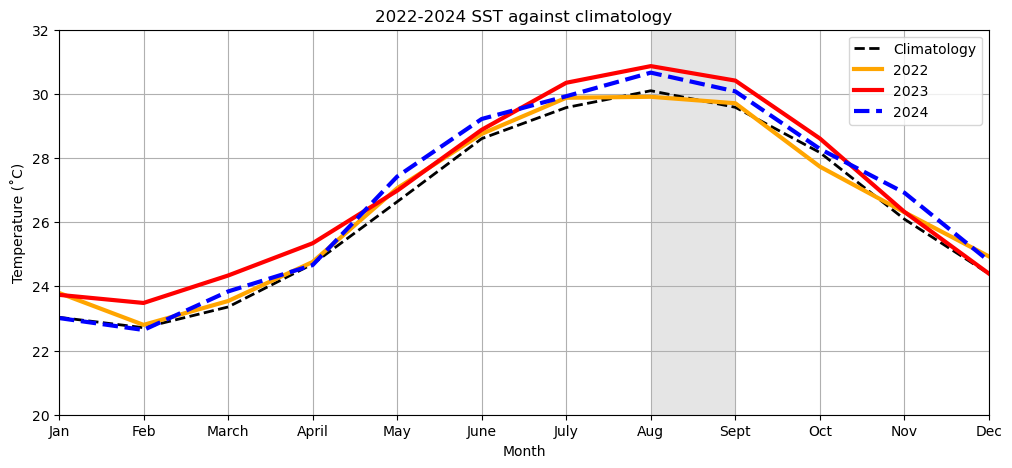

In [48]:
fig4_plot(mo_clim_e_sst, emonthly_filled_sst, unit='Temperature (˚C)', 
          da_name='sst', ylim=(20, 32), title='SST')

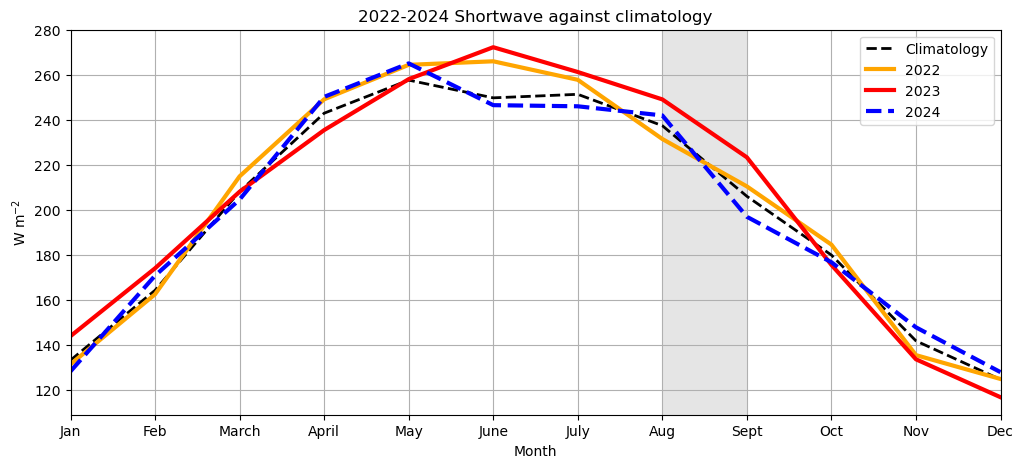

In [49]:
fig4_plot(mo_clim_e_surfs.ssr, emonthly_filled_ssr, unit=r'W m$^{-2}$', da_name='ssr', title='Shortwave')

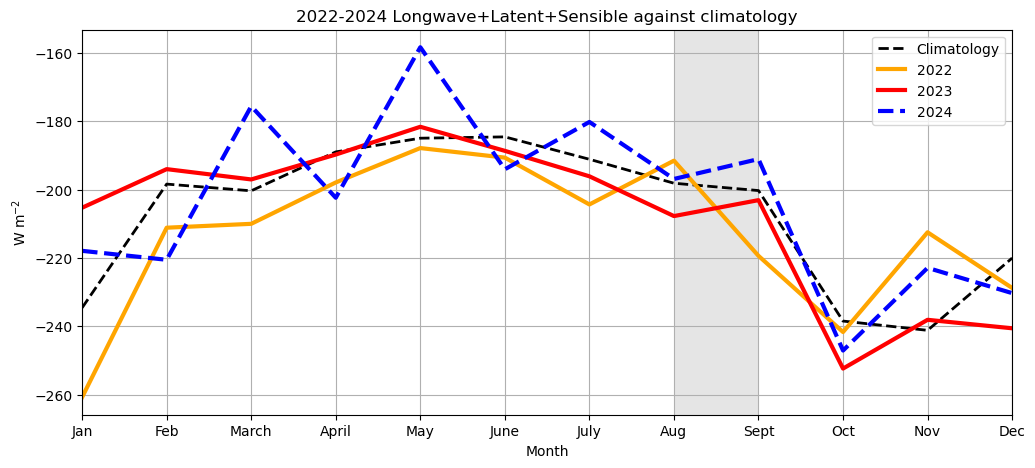

In [50]:
fig4_plot(mo_clim_sans_ssr.to_array().sum('variable'), emonthly_filled_rest, 
          unit=r'W m$^{-2}$', da_name='rest_of_surfs', title='Longwave+Latent+Sensible')

In [18]:
emonthly_filled_ssr.sel(time='2023-06').values

array([272.45560714])

In [19]:
mo_clim_e_surfs.ssr.sel(month=6, method='nearest').values

array(249.94168814)

In [20]:
print('2023 Aug SW was', float(((emonthly_filled_ssr.sel(time='2023-08').values / 
        mo_clim_e_surfs.ssr.sel(month=8, method='nearest').values) - 1)[0]) * 100, '% greater than avg.')

2023 Aug SW was 5.06228769861472 % greater than avg.


In [21]:
print('2023 Aug SW was', float(((emonthly_filled_ssr.sel(time='2023-08').values / 
        mo_clim_e_surfs.ssr.sel(month=8, method='nearest').values) - 1)[0]) * 100, '% greater than avg.')

2023 Aug SW was 5.06228769861472 % greater than avg.


In [22]:
print('2023 June SW was', float(((emonthly_filled_ssr.sel(time='2023-06').values / 
        mo_clim_e_surfs.ssr.sel(month=6, method='nearest').values) - 1)[0]) * 100, '% greater than avg.')

2023 June SW was 9.007668612300513 % greater than avg.


In [23]:
print('2023 June-Aug SW was', float(((emonthly_filled_ssr.sel(time=slice('2023-06', '2023-08')).mean('time') / 
        mo_clim_e_surfs.ssr.sel(month=slice(6,8)).mean('month')) - 1)) * 100, '% greater than avg.')

2023 June-Aug SW was 5.961925254631617 % greater than avg.


In [35]:
print('shortwave in 2023 was:', emonthly_filled_ssr.sel(time=slice('2023-06', '2023-08')).mean('time').values, 'W/m2')

shortwave in 2023 was: 261.0452489178163 W/m2


In [36]:
print('shortwave on avg is:', mo_clim_e_surfs.ssr.sel(month=slice(6,8)).mean('month').values, 'W/m2')

shortwave on avg is: 246.35759334356374 W/m2


In [24]:
mo_clim_sans_ssr.to_array().sum('variable').sel(month=slice(6,8))#.mean('month'))

<xarray.DataArray (month: 3)> Size: 24B
array([-184.55192536, -191.88831952, -198.21008007])
Coordinates:
  * month    (month) int64 24B 6 7 8

In [25]:
print('2023 June-Aug rest of surf terms was', 
      float(((emonthly_filled_rest.sel(time=slice('2023-06', '2023-08')).mean('time') / 
              mo_clim_sans_ssr.to_array().sum('variable').sel(month=slice(6,8)).mean('month')) - 1)) * 100, 
      '% greater than avg.')

2023 June-Aug rest of surf terms was 3.101881247828886 % greater than avg.


In [37]:
print('net surf terms sans SW in 2023 was:', 
      emonthly_filled_rest.sel(time=slice('2023-06', '2023-08')).mean('time').values, 
      'W/m2')

net surf terms sans SW in 2023 was: -197.4917652085626 W/m2


In [38]:
print('net surf terms sans SW on avg is:', 
      mo_clim_sans_ssr.to_array().sum('variable').sel(month=slice(6,8)).mean('month').values, 'W/m2')

net surf terms sans SW on avg is: -191.5501083184371 W/m2


In [41]:
(197.4917652085626 /191.5501083184371 ) - 1

0.03101881247828886

In [42]:
(197 /191 ) - 1

0.03141361256544495

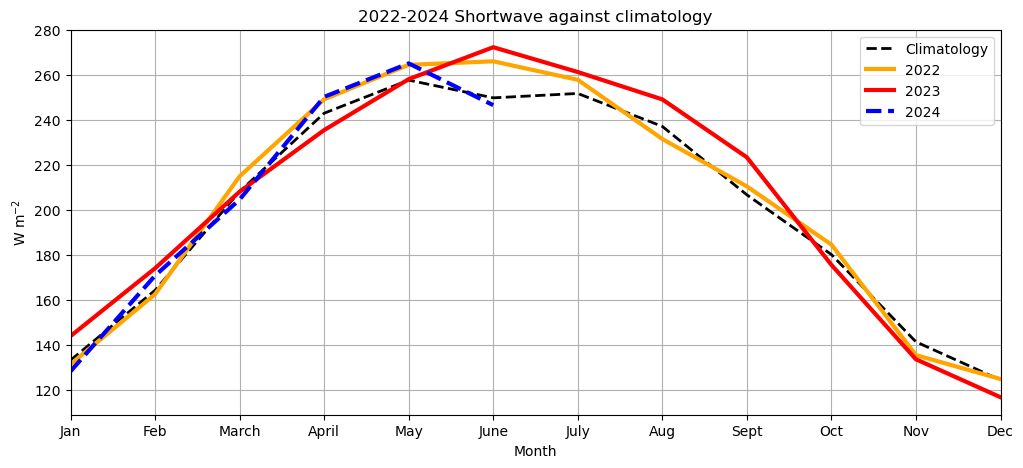

In [26]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 
          'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', ]
plt.figure(figsize=(12,5))
plt.plot(months, mo_clim_e_surfs.ssr, label='Climatology', color='k', linestyle='--', linewidth=2)
plt.plot(months, emonthly_filled_ssr.sel(time=slice('2022', '2022')), label='2022', linewidth=3, color='orange')
plt.plot(months, emonthly_filled_ssr.sel(time=slice('2023', '2023')), label='2023', linewidth=3, color='red')
plt.plot(months, emonthly_filled_ssr.sel(time=slice('2024', '2024')), label='2024', linewidth=3, color='blue',
        linestyle='--')
plt.xlim('Jan', 'Dec')
#plt.ylim(20,32)
plt.grid()
plt.legend()
plt.ylabel(r'W m$^{-2}$')
plt.xlabel('Month')
plt.title('2022-2024 Shortwave against climatology');
#plt.savefig('paper-figs/era/ssr-clim-line-plot.pdf')

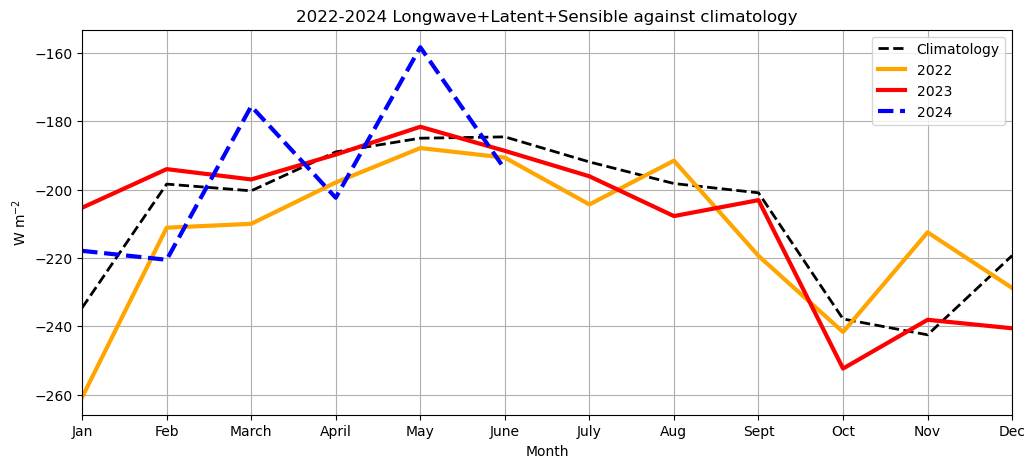

In [28]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 
          'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', ]
plt.figure(figsize=(12,5))
plt.plot(months, mo_clim_sans_ssr.to_array().sum('variable'), label='Climatology', color='k', linestyle='--', linewidth=2)
plt.plot(months, emonthly_filled_rest.sel(time=slice('2022', '2022')), 
         label='2022', linewidth=3, color='orange')
plt.plot(months, emonthly_filled_rest.sel(time=slice('2023', '2023')), 
         label='2023', linewidth=3, color='red')
plt.plot(months, emonthly_filled_rest.sel(time=slice('2024', '2024')), 
         label='2024', linewidth=3, color='blue', linestyle='--')
plt.xlim('Jan', 'Dec')
#plt.ylim(20,32)
plt.grid()
plt.legend()
plt.ylabel(r'W m$^{-2}$')
plt.xlabel('Month')
plt.title('2022-2024 Longwave+Latent+Sensible against climatology');
#plt.savefig('paper-figs/era/rest_of_surfs-clim-line-plot.pdf')